In [1]:
# Import
import pandas as pd
import darts
from darts import TimeSeries
from darts.models import ExponentialSmoothing, ARIMA, Prophet
import matplotlib.pyplot as plt
from darts.utils.utils import SeasonalityMode
from darts.utils.statistics import plot_acf, plot_pacf, check_seasonality, extract_trend_and_seasonality, ModelMode, remove_trend, remove_from_series, stationarity_tests
import glob 
import os
from darts.utils.missing_values import fill_missing_values
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
import sys, os
from math import sqrt
from sklearn.metrics import mean_squared_error
import holoviews as hv
from holoviews import dim, opts
hv.extension('bokeh')
from bokeh.models import ColumnDataSource, HoverTool

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

/home/madadi/anaconda3/envs/main/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'holoviews'

In [ ]:
# Merging all files and making the dataframe
#df = pd.concat(map(pd.read_csv, glob.glob(os.path.join("./data" , "*.csv"))), ignore_index= True)
df = pd.read_csv('0.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Check the existent of nan values 
if df['value'].isna().sum() != 0 :
    df['value'] = fill_mising_values(df['value'])
else:
    print("No missing value")
    

No missing value


In [ ]:
# Too long time series not supported
df = df.head(1000)
df

,timestamp,value,label
0,2014-11-23 06:00:00,-8.957648,0
1,2014-11-23 07:00:00,129.145200,0
2,2014-11-23 08:00:00,219.728758,0
3,2014-11-23 09:00:00,294.941023,0
4,2014-11-23 10:00:00,287.052151,0
...,...,...,...
995,2015-01-03 17:00:00,-101.904305,0
996,2015-01-03 18:00:00,-67.812974,0
997,2015-01-03 19:00:00,9.233512,0
998,2015-01-03 20:00:00,55.950749,0


#### Range we're dealing with

In [ ]:
tmp_df = df
tmp_df['timestamp'] = pd.to_datetime(tmp_df['timestamp'])
print('Start: ',tmp_df['timestamp'].min())
print('End: ',tmp_df['timestamp'].max())
print('Days: ',(tmp_df['timestamp'].max() - tmp_df['timestamp'].min()))
tmp_df

Start:  2014-11-23 06:00:00
End:  2015-01-03 21:00:00
Days:  41 days 15:00:00


,timestamp,value,label
0,2014-11-23 06:00:00,-8.957648,0
1,2014-11-23 07:00:00,129.145200,0
2,2014-11-23 08:00:00,219.728758,0
3,2014-11-23 09:00:00,294.941023,0
4,2014-11-23 10:00:00,287.052151,0
...,...,...,...
995,2015-01-03 17:00:00,-101.904305,0
996,2015-01-03 18:00:00,-67.812974,0
997,2015-01-03 19:00:00,9.233512,0
998,2015-01-03 20:00:00,55.950749,0


#### Resample data from hourly to daily to weekly, and see if we can pick out any interesting features

In [ ]:
Hourly = hv.Curve(tmp_df.set_index('timestamp').resample('H').mean()).opts(
    opts.Curve(title="Value-Hourly", xlabel="", ylabel="Demand",
               width=700, height=300,tools=['hover'],show_grid=True))

Daily = hv.Curve(tmp_df.set_index('timestamp').resample('D').mean()).opts(
    opts.Curve(title="Value-Daily", xlabel="", ylabel="Demand",
               width=700, height=300,tools=['hover'],show_grid=True))

Weekly = hv.Curve(tmp_df.set_index('timestamp').resample('W').mean()).opts(
    opts.Curve(title="Value-Weekly", xlabel="Date", ylabel="Demand",
               width=700, height=300,tools=['hover'],show_grid=True))


(Hourly + Daily + Weekly).opts(shared_axes=False).cols(1)

:Layout
   .Curve.I   :Curve   [value]   (label)
   .Curve.II  :Curve   [value]   (label)
   .Curve.III :Curve   [value]   (label)

## Feature Engineering

#### A variety of resamples which we may or may not use

In [ ]:
df_hourly = tmp_df.set_index('timestamp').resample('H').mean().reset_index()
df_daily = tmp_df.set_index('timestamp').resample('D').mean().reset_index()
df_weekly = tmp_df.set_index('timestamp').resample('W').mean().reset_index()

In [ ]:
# New features 
# Loop to cycle through both DataFrames
for DataFrame in [df_hourly, df_daily]:
    DataFrame['Weekday'] = pd.Categorical(DataFrame['timestamp'].dt.strftime('%A'), categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday', 'Saturday', 'Sunday'])
    DataFrame['Hour'] = DataFrame['timestamp'].dt.hour
    DataFrame['Day'] = DataFrame['timestamp'].dt.weekday
    DataFrame['Month'] = DataFrame['timestamp'].dt.month
    DataFrame['Year'] = DataFrame['timestamp'].dt.year
    DataFrame['Month_day'] = DataFrame['timestamp'].dt.day
    DataFrame['Lag'] = DataFrame['value'].shift(1)
    DataFrame['Rolling_Mean'] = DataFrame['value'].rolling(7).mean()

## Visual Exploration

#### Trying to detect anomales, taking a look at overall distribution

In [ ]:
(hv.Distribution(tmp_df['value'])
.opts(opts.Distribution(title="Overall Value Distribution",
                        xlabel="Value",
                        ylabel="Density",
                        width=700, height=300,
                        tools=['hover'],show_grid=True)
     ))

:Distribution   [value]   (Density)

#### Let's see how this varies by day

In [ ]:
by_weekday = df_hourly.groupby(['Hour','Weekday']).mean()['value'].unstack()
plot = hv.Distribution(by_weekday['Monday'], label='Monday') * hv.Distribution(by_weekday['Tuesday'], label='Tuesday') * hv.Distribution(by_weekday['Wednesday'], label='Wednesday') * hv.Distribution(by_weekday['Thursday'], label='Thursday') * hv.Distribution(by_weekday['Friday'], label='Friday') * hv.Distribution(by_weekday['Saturday'], label='Saturday') *hv.Distribution(by_weekday['Sunday'], label='Sunday').opts(opts.Distribution(title="Demand Density by Day"))
plot.opts(opts.Distribution(width=800, height=300,tools=['hover'],show_grid=True, ylabel="Demand", xlabel="Demand"))

:Overlay
   .Distribution.Monday    :Distribution   [Monday]   (Density)
   .Distribution.Tuesday   :Distribution   [Tuesday]   (Density)
   .Distribution.Wednesday :Distribution   [Wednesday]   (Density)
   .Distribution.Thursday  :Distribution   [Thursday]   (Density)
   .Distribution.Friday    :Distribution   [Friday]   (Density)
   .Distribution.Saturday  :Distribution   [Saturday]   (Density)
   .Distribution.Sunday    :Distribution   [Sunday]   (Density)

#### Let's see how this varies by day ( Barchart ) 

In [ ]:
hv.Bars(df_hourly[['value','Weekday']].groupby('Weekday').mean()).opts(
    opts.Bars(title="Demand by Day", xlabel="", ylabel="Demand",
               width=700, height=300,tools=['hover'],show_grid=True))

:Bars   [Weekday]   (value)

#### Average hourly and daily demand

In [ ]:
hv.Curve(df_hourly[['value','Hour']].groupby('Hour').mean()).opts(
    opts.Curve(title="Demand Hourly", xlabel="Hour", ylabel="Demand",
               width=700, height=300,tools=['hover'],show_grid=True))

:Curve   [Hour]   (value)

In [ ]:
by_weekday = df_hourly.groupby(['Hour','Weekday']).mean()['value'].unstack()
plot = hv.Curve(by_weekday['Monday'], label='Monday') * hv.Curve(by_weekday['Tuesday'], label='Tuesday') * hv.Curve(by_weekday['Wednesday'], label='Wednesday') * hv.Curve(by_weekday['Thursday'], label='Thursday') * hv.Curve(by_weekday['Friday'], label='Friday') * hv.Curve(by_weekday['Saturday'], label='Saturday') *hv.Curve(by_weekday['Sunday'], label='Sunday').opts(opts.Curve(title="Average Demand by Day & Hour"))
plot.opts(opts.Curve(width=800, height=300,tools=['hover'],show_grid=True, ylabel="Demand"))

:Overlay
   .Curve.Monday    :Curve   [Hour]   (Monday)
   .Curve.Tuesday   :Curve   [Hour]   (Tuesday)
   .Curve.Wednesday :Curve   [Hour]   (Wednesday)
   .Curve.Thursday  :Curve   [Hour]   (Thursday)
   .Curve.Friday    :Curve   [Hour]   (Friday)
   .Curve.Saturday  :Curve   [Hour]   (Saturday)
   .Curve.Sunday    :Curve   [Hour]   (Sunday)

## More Feature Engineering

In [ ]:
df_hourly = df_hourly.join(df_hourly.groupby(['Hour','Weekday'])['value'].mean(),
on = ['Hour', 'Weekday'], rsuffix='_Average')
df_hourly.head()

,timestamp,value,label,Weekday,Hour,Day,Month,Year,Month_day,Lag,Rolling_Mean,value_Average
0,2014-11-23 06:00:00,-8.957648,0.0,Sunday,6,6,11,2014,23,NaN,NaN,1.366163
1,2014-11-23 07:00:00,129.145200,0.0,Sunday,7,6,11,2014,23,-8.957648,NaN,131.346452
2,2014-11-23 08:00:00,219.728758,0.0,Sunday,8,6,11,2014,23,129.145200,NaN,230.772578
3,2014-11-23 09:00:00,294.941023,0.0,Sunday,9,6,11,2014,23,219.728758,NaN,289.958501
4,2014-11-23 10:00:00,287.052151,0.0,Sunday,10,6,11,2014,23,294.941023,NaN,287.822340


In [ ]:
df_daily = df_daily.join(df_daily.groupby(['Hour','Weekday'])['value'].mean(),
on = ['Hour', 'Weekday'], rsuffix='_Average')

## Model

#### Droping the Null values created by the new features

In [ ]:
# check! better approches for filling nan values!

df_daily = df_daily.dropna()
df_hourly = df_hourly.dropna()
df_hourly.head()

,timestamp,value,label,Weekday,Hour,Day,Month,Year,Month_day,Lag,Rolling_Mean,value_Average
6,2014-11-23 12:00:00,200.745368,0.0,Sunday,12,6,11,2014,23,270.454642,199.015642,174.261535
7,2014-11-23 13:00:00,75.920252,0.0,Sunday,13,6,11,2014,23,200.745368,211.141056,86.242835
8,2014-11-23 14:00:00,49.195654,0.0,Sunday,14,6,11,2014,23,75.920252,199.719693,35.128729
9,2014-11-23 15:00:00,-7.675757,0.0,Sunday,15,6,11,2014,23,49.195654,167.233333,-27.528275
10,2014-11-23 16:00:00,-14.716344,0.0,Sunday,16,6,11,2014,23,-7.675757,122.996567,-12.303204


#### Choosing Features for our model

In [ ]:
df_daily_model_data = df_daily[['value', 'Hour', 'Day',  'Month','Month_day','Rolling_Mean']].dropna()
model_data = df_hourly[['value', 'Hour', 'Day', 'Month_day', 'Month','Rolling_Mean','Lag']]
model_data.head()

,value,Hour,Day,Month_day,Month,Rolling_Mean,Lag
6,200.745368,12,6,23,11,199.015642,270.454642
7,75.920252,13,6,23,11,211.141056,200.745368
8,49.195654,14,6,23,11,199.719693,75.920252
9,-7.675757,15,6,23,11,167.233333,49.195654
10,-14.716344,16,6,23,11,122.996567,-7.675757


#### Now let fit the Isolation Forest Model and View Outliers

In [ ]:
IF = IsolationForest(random_state=0, contamination=0.005, n_estimators=200, max_samples=0.7)
IF.fit(model_data)

# New Column for Outliers
df_hourly['Outliers'] = pd.Series(IF.predict(model_data)).apply(lambda x: 1 if x == -1 else 0)

# Get Anomaly Score
df_hourly['Score'] = IF.decision_function(model_data)

df_hourly.head()

,timestamp,value,label,Weekday,Hour,Day,Month,Year,Month_day,Lag,Rolling_Mean,value_Average,Outliers,Score
6,2014-11-23 12:00:00,200.745368,0.0,Sunday,12,6,11,2014,23,270.454642,199.015642,174.261535,0.0,0.078343
7,2014-11-23 13:00:00,75.920252,0.0,Sunday,13,6,11,2014,23,200.745368,211.141056,86.242835,0.0,0.087945
8,2014-11-23 14:00:00,49.195654,0.0,Sunday,14,6,11,2014,23,75.920252,199.719693,35.128729,0.0,0.098673
9,2014-11-23 15:00:00,-7.675757,0.0,Sunday,15,6,11,2014,23,49.195654,167.233333,-27.528275,0.0,0.097760
10,2014-11-23 16:00:00,-14.716344,0.0,Sunday,16,6,11,2014,23,-7.675757,122.996567,-12.303204,0.0,0.104201


##### We can now see the anomaly scores for each data point. The lower, the more abnormal. Negative scores represent outliers, positive scores represent inliers.

## Viewing the Anomalies

In [ ]:
tooltips = [
    ('Weekday', '@Weekday'),
    ('Day', '@Month_day'),
    ('Month', '@Month'),
    ('Value', '@value'),
    ('Average Vale', '@value_Average'),
    ('Outliers', '@Outliers')
]
hover = HoverTool(tooltips=tooltips)

hv.Points(df_hourly.query("Outliers == 1")).opts(size=10, color='#ff0000') * hv.Curve(df_hourly).opts(opts.Curve(title="Demand Anomalies", xlabel="", ylabel="Demand" , height=300, responsive=True,tools=[hover,'box_select', 'lasso_select', 'tap'],show_grid=True))

:Overlay
   .Points.I :Points   [timestamp,value]   (label,Weekday,Hour,Day,Month,Year,Month_day,Lag,Rolling_Mean,value_Average,Outliers,Score)
   .Curve.I  :Curve   [timestamp]   (value,label,Weekday,Hour,Day,Month,Year,Month_day,Lag,Rolling_Mean,value_Average,Outliers,Score)

In [ ]:
len(df_hourly.query("Outliers == 1"))

5

In [ ]:
frequencies, edges = np.histogram(score, 50)
print('Values: %s, Edges: %s' % (frequencies.shape[0], edges.shape[0]))
hv.Histogram((edges, frequencies)).opts(width=800, height=300,tools=['hover'], xlabel='Score')

Values: 50, Edges: 51


:Histogram   [x]   (Frequency)

In [ ]:
# Function to view number of outliers at a given threshold
outliers(0.05)

Number of Outliers below Anomaly Score Threshold 0.05:
1


In [ ]:
tooltips = [
    ('Weekday', '@Weekday'),
    ('Day', '@Month_day'),
    ('Month', '@Month'),
    ('Value', '@value'),
    ('Average Vale', '@value_Average'),
    ('Outliers', '@Outliers')
]
hover = HoverTool(tooltips=tooltips)

hv.Points(df_hourly.query("Outliers == 1 & Score <= 0.05")).opts(size=10, color='#ff0000') * hv.Curve(df_hourly).opts(opts.Curve(title="Demand", xlabel="", ylabel="Demand" , height=300, responsive=True,tools=[hover,'box_select', 'lasso_select', 'tap'],show_grid=True))

:Overlay
   .Points.I :Points   [timestamp,value]   (label,Weekday,Hour,Day,Month,Year,Month_day,Lag,Rolling_Mean,value_Average,Outliers,Score)
   .Curve.I  :Curve   [timestamp]   (value,label,Weekday,Hour,Day,Month,Year,Month_day,Lag,Rolling_Mean,value_Average,Outliers,Score)

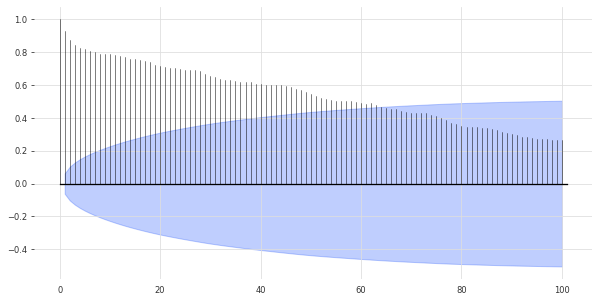

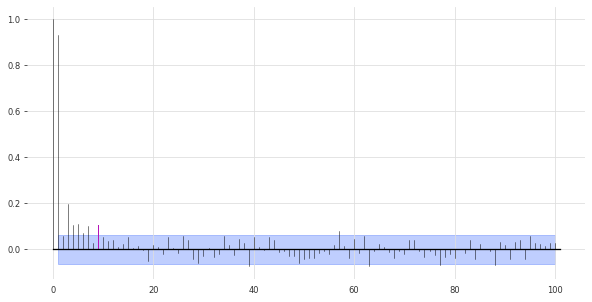

In [ ]:
plot_acf(series, max_lag=100)
plot_pacf(series, 9, max_lag=100)